Our goal was to demonstrate how Echo State Networks can be used for prediction of dynamical systems behaviour and to compare it to other methods not connected with Reservoir computing.
There is not much software available for ESNs. We decided to use EchoTorch: https://github.com/nschaetti/EchoTorch which is ESN library integrated with PyTorch.

Note: When installing don't use pip install echotorch. Instead call 'pip install git+https://github.com/nschaetti/EchoTorch'

In [5]:
import echotorch as echo
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [6]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

Let's start with Mackey-Glass problem with dataset generated as in https://iopscience.iop.org/article/10.1088/1742-6596/720/1/012002/pdf


In [7]:

import torch
from torch.utils.data.dataset import Dataset
import collections

class MackeyGlassDataset2(Dataset):
    def __init__(self, sample_len, n_samples,tau=17,delta=6,x0=1.2,alpha=0.2,beta=0.1,delay=1, seed=None):
        self.sample_len = sample_len
        self.n_samples = n_samples
        self.tau = tau
        self.delta = delta
        self.x0 = x0
        self.alpha=alpha
        self.beta=beta
        self.past = [self.x0] * (self.delta * self.tau)
        self.delay=delay

        if seed is not None:
            torch.manual_seed(seed)

    def __len__(self): # 1 for our use case
        return self.n_samples

    def __getitem__(self, idx):
        series = torch.zeros(self.sample_len+self.delay, 1)

        for timestep in range(self.sample_len+self.delay):
            for _ in range(self.delta):
                x_tau = self.past.pop(0)
                x_t = self.past[-1]
                x_t1 = x_t + (((self.alpha * x_tau) / (1 + x_tau**10))-self.beta * x_t)
                self.past.append(x_t1)
                
            series[timestep] = self.past[-1]
        
        inputs = torch.tan(series-1)

        # Squash timeseries through tanh
        return inputs[:-self.delay], inputs[self.delay:]

In [10]:
import random

def random_grid_search(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=None
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.LiESN(
            input_dim=1,
            hidden_dim=int(hid),
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=leak
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
        rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
        if not min_mse or mse < min_mse:
            min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
        mses.append(mse)
    
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        
        
    


min_mse: 0.0007783572073094547; min_rmse: 0.027899053878392626
 for hid=87, rad=1.2721629303427655,leak=0.7089140994447041


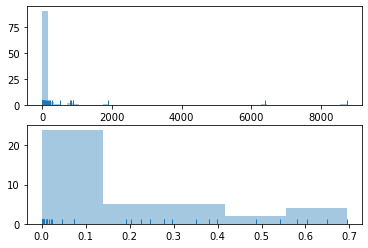

min_mse: 0.0010649545583873987; min_rmse: 0.032633641512822296
 for hid=172, rad=1.161277686303599,leak=0.9810681967359605


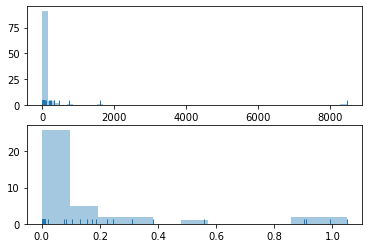

min_mse: 0.0007988843135535717; min_rmse: 0.028264541629992368
 for hid=123, rad=1.2023865211489566,leak=0.9304898717716503


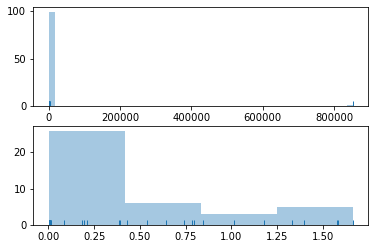

min_mse: 0.0009816839592531323; min_rmse: 0.03133183619344918
 for hid=98, rad=1.2295835935811588,leak=0.856420045774896


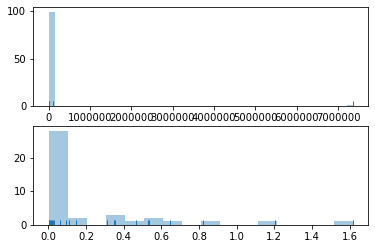

min_mse: 0.0007515327888540924; min_rmse: 0.027414098359313084
 for hid=131, rad=1.2550352753586382,leak=0.8196966348980792


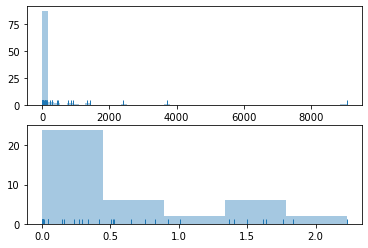

min_mse: 0.0007042328943498433; min_rmse: 0.026537386727970094
 for hid=103, rad=1.2024418638314722,leak=0.7026897634660333


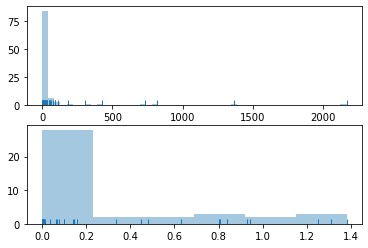

min_mse: 0.000767716090194881; min_rmse: 0.027707690091288394
 for hid=85, rad=1.2094192431279713,leak=0.6174743353806904


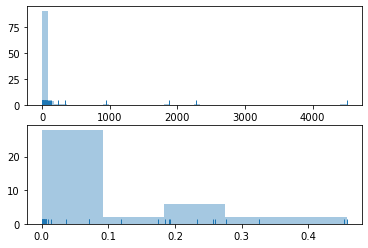

min_mse: 0.0010205633006989956; min_rmse: 0.03194625644264122
 for hid=88, rad=1.2030277568037258,leak=0.6930234958284426


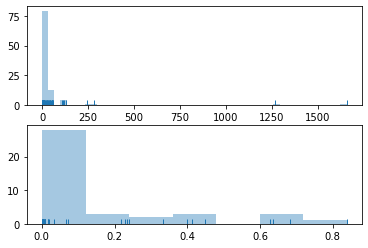

min_mse: 0.0010691791540011764; min_rmse: 0.03269830506312485
 for hid=113, rad=1.2043348471944675,leak=0.9580667473943429


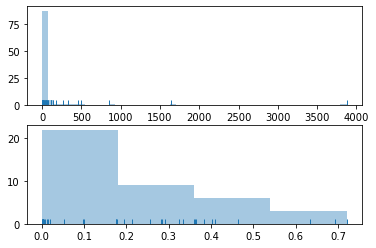

min_mse: 0.0008928489405661821; min_rmse: 0.029880577982465167
 for hid=99, rad=1.1623519001250138,leak=0.9008956429783341


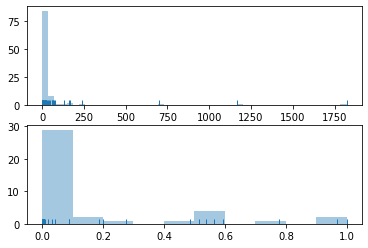

In [11]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 1000
n_train_samples = 2

for i in range(10):
    train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
    trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
    trainiter = iter(trainloader)
    min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search(
        trainiter.next(),
        trainiter.next(),
        hidden_range=[80,200],
        radius_range=[0.8,1.3],
        leaky_range=[0.5,0.99],
        num_samples=100
        )
    print(f'min_mse: {min_mse}; min_rmse: {min_rmse}\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}')
    fig, axs = plt.subplots(2)
    sns.distplot(mses,rug=True,kde=False,ax = axs[0])

    sns.distplot(sorted(mses)[:40],rug=True,kde=False,ax = axs[1])
    
    plt.show()

Test MSE: 0.0020879528019577265
Test RMSE: 0.04569412218171749


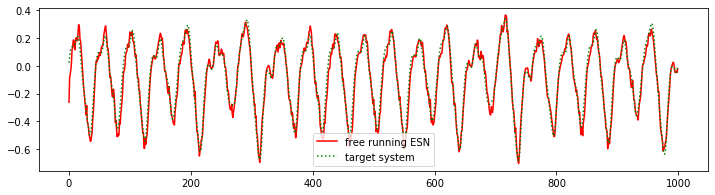

In [12]:

train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.LiESN(
    input_dim=1,
    hidden_dim=104,
    output_dim=1,
    spectral_radius=1.2966,
    learning_algo='inv',
    leaky_rate=0.867
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test RMSE: {}".format(echotorch.utils.rmse(y_predicted.data, test_y.data)))

plt.figure(figsize=(12,3))
plt.plot(range(train_sample_length),list(y_predicted.data.reshape((-1,))[0:]),'r-', label="free running ESN")
plt.plot(range(train_sample_length),list(test_y.data.reshape((-1,))[0:]),'g:',label="target system")
plt.legend()
plt.show()

Let's compare to results shown in:https://iopscience.iop.org/article/10.1088/1742-6596/720/1/012002/pdf

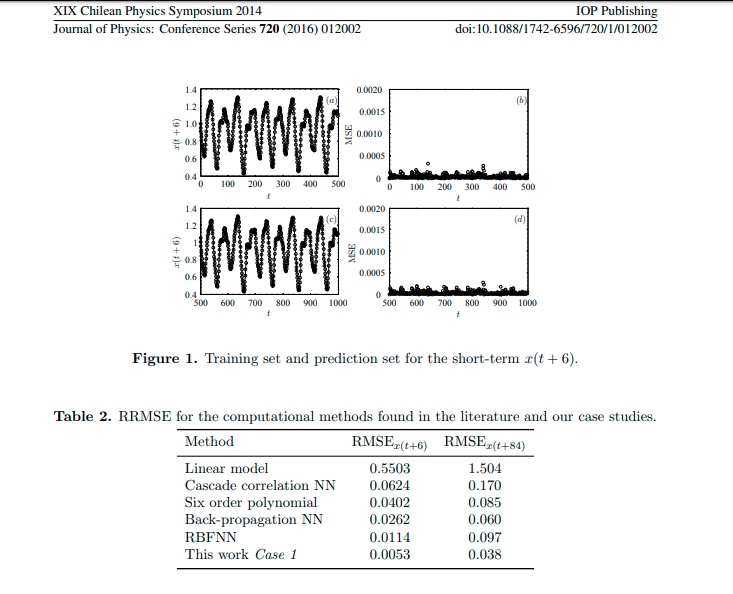


We can see that simple Echo State Network with some parameter tuning can estimate MackeyGlass 6 steps ahead on level comparable to "Back-propagation NN" but not at good as shown in this paper
Moreover ESN are randomly initialized. They are fast but sometimes unstable what can be seen on histograms above

In [13]:
import random

def random_grid_search_stacked(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=None
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.StackedESN(
            input_dim=1,
            hidden_dim=[int(hid),int(hid),int(hid)],
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=[leak,leak,leak]
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
        rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
        if not min_mse or mse < min_mse:
            min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
        mses.append(mse)
    
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        
        
    


min_mse: 0.0008245580247603357; min_rmse: 0.028715118400597546
 for hid=165, rad=1.351661925085141,leak=0.8316915453740941


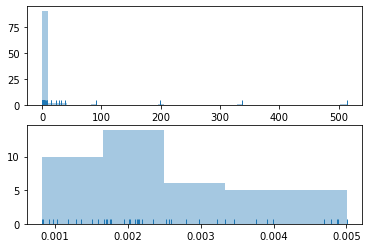

min_mse: 0.0005949129699729383; min_rmse: 0.02439083782843341
 for hid=118, rad=1.5226113883110137,leak=0.80025572323512


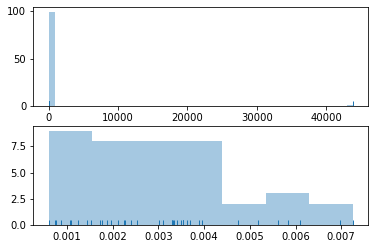

min_mse: 0.0006222219672054052; min_rmse: 0.024944377466784077
 for hid=121, rad=1.4909469493179404,leak=0.8504213742095434


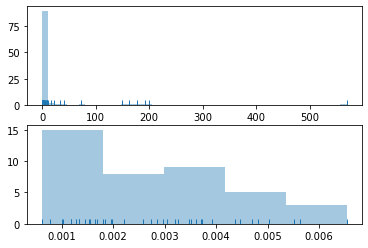

min_mse: 0.0005822225357405841; min_rmse: 0.024129287924441203
 for hid=102, rad=1.376062088658941,leak=0.8474322130806419


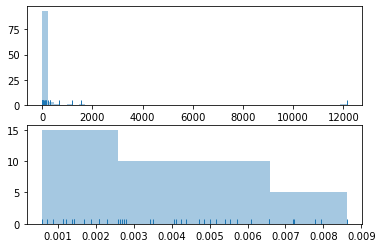

min_mse: 0.0007542261155322194; min_rmse: 0.027463177447852233
 for hid=159, rad=1.378396749548671,leak=0.8342229846773674


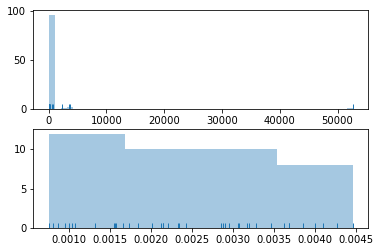

min_mse: 0.0007881049532443285; min_rmse: 0.02807320703525567
 for hid=114, rad=1.2933395750123622,leak=0.8856339621848173


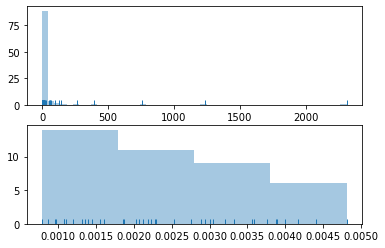

min_mse: 0.0006379805854521692; min_rmse: 0.025258277563051865
 for hid=124, rad=1.2108594071711662,leak=0.8357461798565882


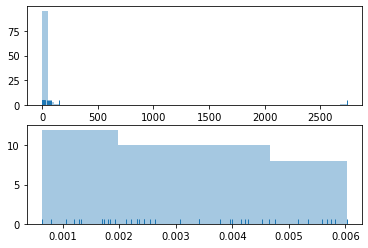

min_mse: 0.0009432636434212327; min_rmse: 0.03071259747109047
 for hid=159, rad=1.5082784266366036,leak=0.8788135991276118


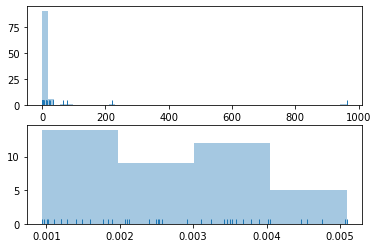

min_mse: 0.0009330046596005559; min_rmse: 0.03054512497274411
 for hid=102, rad=1.1174653512820791,leak=0.9485448265874938


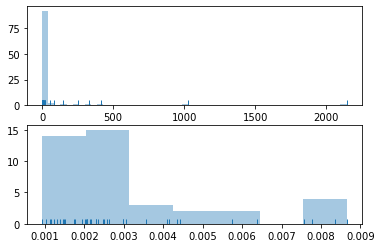

min_mse: 0.0008234325796365738; min_rmse: 0.0286955149742355
 for hid=121, rad=1.2893747091746073,leak=0.8888859233006885


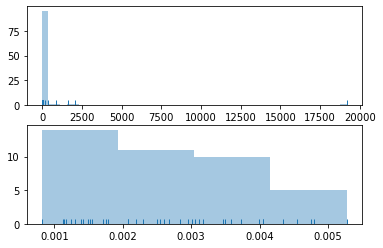

In [14]:

from echotorch.datasets.MackeyGlassDataset import MackeyGlassDataset
import echotorch.nn as etnn
import echotorch.utils
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader

# Dataset params
train_sample_length = 1000
n_train_samples = 2

for i in range(10):
    train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=6)
    trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
    trainiter = iter(trainloader)
    min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search_stacked(
        trainiter.next(),
        trainiter.next(),
        hidden_range=[100,180],
        radius_range=[1,1.6],
        leaky_range=[0.8,0.95],
        num_samples=100
        )
    print(f'min_mse: {min_mse}; min_rmse: {min_rmse}\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}')
    fig, axs = plt.subplots(2)
    sns.distplot(mses,rug=True,kde=False,ax = axs[0])

    sns.distplot(sorted(mses)[:40],rug=True,kde=False,ax = axs[1])
    
    plt.show()

after introducing StackedESN  wee see slightly better improvement in best results (RMSE = 0.026) but far more better stability of ESN

Let's make some changes to dataset to be able to compare our results to ones obtained in this paper: https://dl.acm.org/doi/10.1145/3305160.3305187 

In [15]:
def R2(predicted_data,actual_data,horizon=0):
    predicted = predicted_data.numpy()[0,-horizon:,0]
    actual = actual_data.numpy()[0,-horizon:,0]
    avg = np.average(actual)
    div_up = predicted-actual
    div_down = actual-avg
    return 1 - np.sum((div_up*div_up))/np.sum((div_down*div_down))

In [16]:
import random

def random_grid_search_stacked_ahead(train_data,test_data,hidden_range,radius_range,leaky_range,num_samples,horizon=30):
    train_inputs,train_targets = train_data
    test_inputs,test_targets = test_data
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    max_r2=None
    min_hidden,min_radius,min_leaky=None,None,None
    r2s = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.StackedESN(
            input_dim=1,
            hidden_dim=[int(hid),int(hid),int(hid),int(hid),int(hid)],
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=[leak,leak,leak,leak,leak]
        )
        esn(train_inputs, train_targets)
        esn.finalize()
        y_predicted = esn(test_inputs)
        r2 = R2(y_predicted.data,test_targets.data,horizon=horizon)
        if not max_r2 or r2 > max_r2:
            max_r2,min_hidden,min_radius,min_leaky=r2,hid,rad,leak
        r2s.append(r2)
    
    return max_r2,min_hidden,min_radius,min_leaky,r2s
        
        
    


In [18]:


# Dataset params
train_sample_length = 2000
n_train_samples = 2
horizons=[30,50,70]

for h in horizons:
    for i in range(5):
        train = MackeyGlassDataset2(train_sample_length, n_train_samples, tau=17,delta=1,delay=h)
        trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
        trainiter = iter(trainloader)
        r2,min_hidden,min_radius,min_leaky,r2s = random_grid_search_stacked_ahead(
            trainiter.next(),
            trainiter.next(),
            hidden_range=[100,180],
            radius_range=[1,1.6],
            leaky_range=[0.8,0.95],
            num_samples=40,
            horizon=h
            )
        print(f'for horizon {h}: max_r2: {r2};\n for hid={min_hidden}, rad={min_radius},leak={min_leaky}\n')

for horizon 30: max_r2: 0.9945165570825338;
 for hid=136, rad=1.4583722320314911,leak=0.8845938334747132

for horizon 30: max_r2: 0.9936775420792401;
 for hid=164, rad=1.2680057766257438,leak=0.9111093345809139

for horizon 30: max_r2: 0.9955728692002594;
 for hid=177, rad=1.2662744075507208,leak=0.9269742532410122

for horizon 30: max_r2: 0.9973259666003287;
 for hid=151, rad=1.3870325252786406,leak=0.9482277878699672

for horizon 30: max_r2: 0.9930409933440387;
 for hid=103, rad=1.2193951435947676,leak=0.8071162295449116

for horizon 50: max_r2: 0.9933787775225937;
 for hid=155, rad=1.3166071613346286,leak=0.8251637543919909

for horizon 50: max_r2: 0.9939803127199411;
 for hid=149, rad=1.4725918022068862,leak=0.8099486029113507

for horizon 50: max_r2: 0.9847935577854514;
 for hid=112, rad=1.323580113359958,leak=0.9084124929150501

for horizon 50: max_r2: 0.9853427158668637;
 for hid=143, rad=1.2753435608897064,leak=0.8411898490362315

for horizon 50: max_r2: 0.9660157114267349;
 fo

When comparing to results from the paper above - stackedESN seems to be much more stable solution
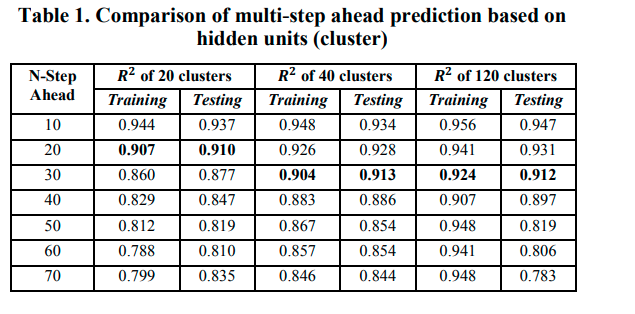

Our results decrease just a tiny bit comparing to theirs

Test R2: 0.9276553317904472


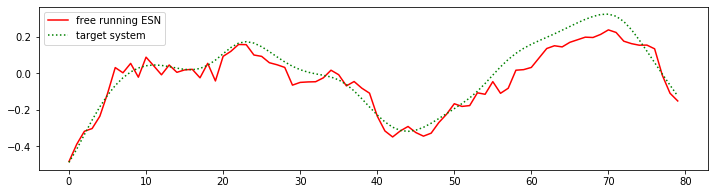

In [19]:
horizon =70
train = MackeyGlassDataset2(2000, 2, tau=17,delta=1,delay=horizon)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.StackedESN(
    input_dim=1,
    hidden_dim=[154,154,154,154],
    output_dim=1,
    spectral_radius=1.246,
    learning_algo='inv',
    leaky_rate=[0.820,0.820,0.820,0.820]
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test R2: {}".format(R2(y_predicted.data, test_y.data)))

plt.figure(figsize=(12,3))
plt.plot(range(horizon+10),list(y_predicted.data.reshape((-1,))[-(horizon+10):]),'r-', label="free running ESN")
plt.plot(range(horizon+10),list(test_y.data.reshape((-1,))[-(horizon+10):]),'g:',label="target system")
plt.legend()
plt.show()

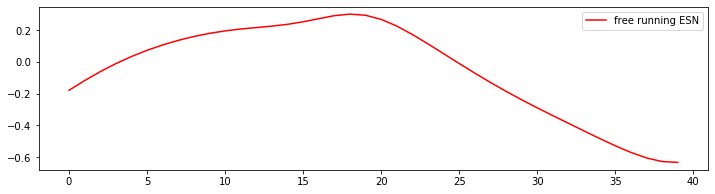

In [20]:
plt.figure(figsize=(12,3))
plt.plot(range(40),list(targets.data.reshape((-1,))[-20:]) + list(test_u.data.reshape((-1,))[:20]),'r-', label="free running ESN")
# plt.plot(range(19,39),list(test_u.data.reshape((-1,))[:20]),'g:',label="target system")
plt.legend()
plt.show()

Test R2: 0.5247833728790283


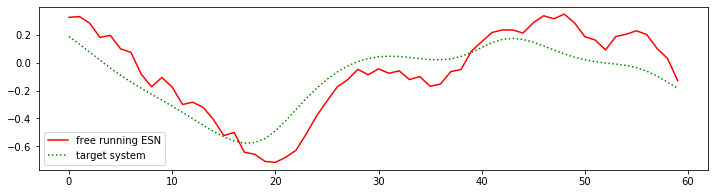

In [21]:

horizon =50
train = MackeyGlassDataset2(2000, 2, tau=17,delta=1,delay=horizon)
trainloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=1)
esn = etnn.StackedESN(
    input_dim=1,
    hidden_dim=[154,154,154,154],
    output_dim=1,
    spectral_radius=1.246,
    learning_algo='inv',
    leaky_rate=[0.820,0.820,0.820,0.820]
)


dataiter = iter(trainloader)
data = dataiter.next()
#train
inputs, targets = data
esn(inputs, targets)
esn.finalize()

test_u, test_y = dataiter.next()
y_predicted = esn(test_u)
print(u"Test R2: {}".format(R2(y_predicted.data, test_y.data,horizon)))

plt.figure(figsize=(12,3))
plt.plot(range(horizon+10),list(y_predicted.data.reshape((-1,))[-(horizon+10):]),'r-', label="free running ESN")
plt.plot(range(horizon+10),list(test_y.data.reshape((-1,))[-(horizon+10):]),'g:',label="target system")
plt.legend()
plt.show()

In [22]:
inp = inputs
for i in range(3):
    inp = esn(inp)

extraplatin doesn't however seem to be working well

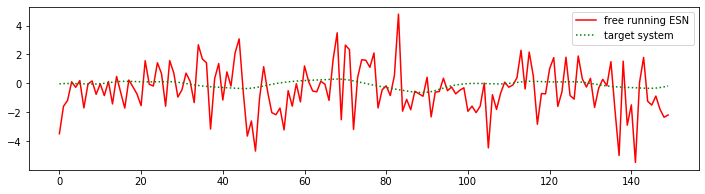

In [23]:
# extrapolating 100 not seen samples
plt.figure(figsize=(12,3))
plt.plot(range(3*horizon),list(inp.data.reshape((-1,))[-(3*horizon):]),'r-', label="free running ESN")
plt.plot(range(3*horizon),list(targets.data.reshape((-1,))[-(horizon):]) + list(test_u.data.reshape((-1,))[:2*horizon]),'g:',label="target system")
plt.legend()
plt.show()

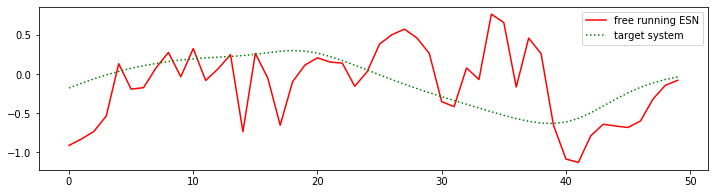

In [24]:
numho = 2
inp = inputs
for i in range(numho):
    inp = esn(inp)
plt.figure(figsize=(12,3))
plt.plot(range((numho-1)*horizon),list(inp.data.reshape((-1,))[-((numho-1)*horizon):]),'r-', label="free running ESN")
plt.plot(range((numho-1)*horizon),list(test_u.data.reshape((-1,))[:(numho-1)*horizon]),'g:',label="target system")
plt.legend()
plt.show()
#however 50 samples work qiute ok

Now let's look at whether data

In [25]:
import pandas as pd


In [27]:
yearly = pd.read_csv("yearly_polution.csv")

In [28]:
daily_avg=yearly.groupby(['date_local']).mean()

In [29]:
daily_avg.head()

,aqi
date_local,
1990-01-01,63.200000
1990-01-02,20.266667
1990-01-03,39.933333
1990-01-04,53.066667
1990-01-05,59.200000


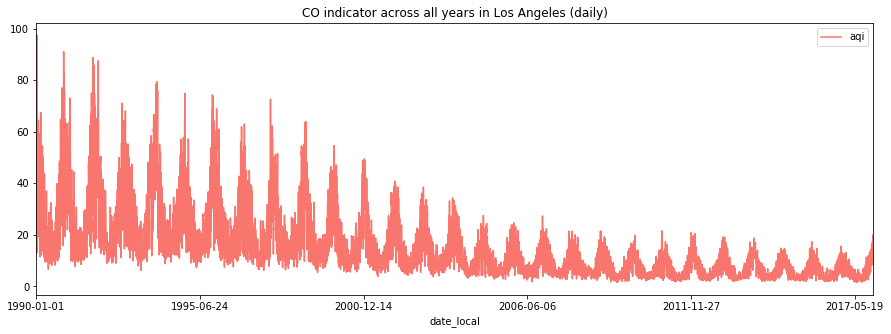

In [30]:
daily_avg.plot(style='-', figsize=(15,5), color="#F8766D", title='CO indicator across all years in Los Angeles (daily)')

In [31]:
class WindowDataset(Dataset):
    def __init__(self, data,features_len=100,prediction_len=1):
        self.data = data
        self.features_len = features_len
        self.prediction_len = prediction_len 

    def __len__(self): # 1 for our use case
        return (len(self.data)-self.features_len) // (self.prediction_len)

    def __getitem__(self, idx):
        start_train = idx*self.prediction_len
        end_train = start_train + self.features_len
        start_pred=end_train
        end_pred = start_pred + self.prediction_len
        return torch.tensor(self.data[start_train:end_train]).reshape((-1,1)),torch.tensor(self.data[start_pred:end_pred]).reshape((-1,1))
        
class ShiftedDataset(Dataset):
    def __init__(self, data,features_len=100,shift=1):
        self.data = data
        self.features_len = features_len
        self.shift = shift 

    def __len__(self): # 1 for our use case
        return (len(self.data)-self.shift) // (self.features_len)

    def __getitem__(self, idx):
        start_train = idx
        end_train = start_train + self.features_len
        start_pred=idx+self.shift
        end_pred = start_pred + self.features_len
        return torch.tensor(self.data[start_train:end_train]).reshape((-1,1)),torch.tensor(self.data[start_pred:end_pred]).reshape((-1,1))
        

In [32]:
data = daily_avg['aqi'].values.astype(np.float32)
len(data)

10227

In [33]:
X_train,X_test=data[:8200],data[8200:10220]

Library doesn't allow to use different features_len and prediction_len :/
It also can't solve the given problem with stackedESN - either uses method that does not exist in torch or encounters a singular matrix 

<class 'tuple'>
torch.Size([4, 100, 1])


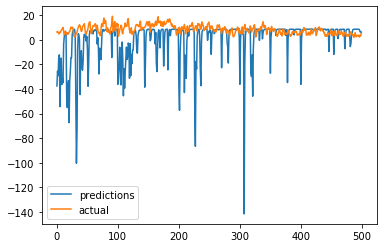

In [34]:
train_ds = WindowDataset(X_train,features_len=100,prediction_len=100)
test_ds = WindowDataset(X_test,features_len=100,prediction_len=100)

trainloader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=1)
testloader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)

esn = etnn.LiESN(
    input_dim=1,
    hidden_dim=154,#[154,154,154,154],
    output_dim=1,
    spectral_radius=1.246,
    learning_algo='inv',
    leaky_rate=0.82#[0.820,0.820,0.820,0.820]
)

for data in trainloader:
    inputs, targets = data
    esn(inputs, targets)

esn.finalize()

# training done

prediction = [(esn(x_sample),y_sample) for (x_sample,y_sample) in testloader]
xs,ys = zip(*prediction)
print(type(xs))
print(xs[0].shape)
pred = np.hstack([x.data[0,:,0] for x in xs])
pred = pred - np.average(pred)
plt.plot(pred,label='predictions')
plt.plot(np.hstack([y.data[0,:,0] for y in ys]),label='actual')
plt.legend()
plt.show()


In [35]:
def random_grid_search_iter(trainloader,testloader,hidden_range,radius_range,leaky_range,num_samples):
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=None
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        esn = etnn.LiESN(
            input_dim=1,
            hidden_dim=int(hid),
            output_dim=1,
            spectral_radius=rad,
            learning_algo='inv',
            leaky_rate=leak
        )
        for data in trainloader:
            inputs, targets = data
            esn(inputs, targets)
        esn.finalize()
        prediction = [(esn(x_sample),y_sample) for (x_sample,y_sample) in testloader]
        xs,ys = zip(*prediction)
        y_predicted = torch.cat(xs)
        test_targets=torch.cat(ys)
        mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
        rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
        if not min_mse or mse < min_mse:
            min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
        mses.append(mse)
    
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        

In [36]:
min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search_iter(trainloader,testloader,hidden_range=[100,500],radius_range=[0.8,1.3],leaky_range=[0.7,0.95],num_samples=100)

stosunkowo ciężko znaleźć dobre dopasowanie:

Text(0.5, 1.0, '40 ze 100')

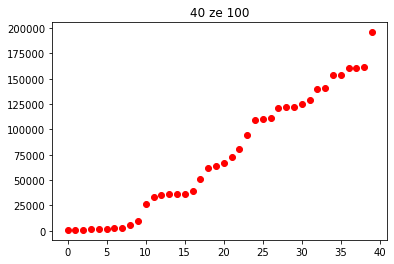

In [37]:
mses_sorted = sorted(mses)[:40]
plt.plot(range(len(mses_sorted)),mses_sorted,'ro')
plt.title("40 ze 100")

Text(0.5, 1.0, '80 ze 100')

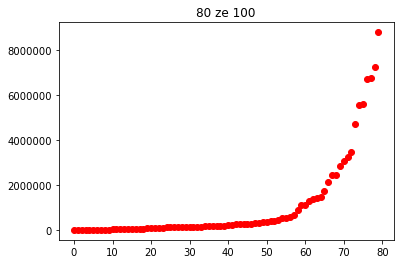

In [38]:
mses_sorted = sorted(mses)[:80]
plt.plot(range(len(mses_sorted)),mses_sorted,'ro')
plt.title("80 ze 100")

Text(0.5, 1.0, '100 ze 100')

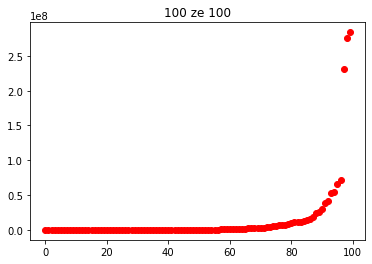

In [39]:
mses_sorted = sorted(mses)
plt.plot(range(len(mses_sorted)),mses_sorted,'ro')
plt.title("100 ze 100")

In [40]:
print(f"min_hidden={min_hidden},min_radius={min_radius},min_leaky={min_leaky}")

min_hidden=105,min_radius=1.1553457392630437,min_leaky=0.8221756666183537


<class 'tuple'>
torch.Size([4, 100, 1])


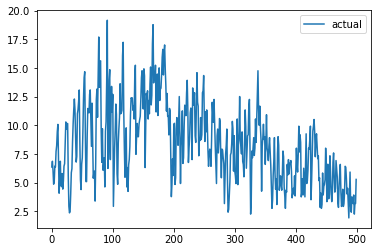

In [41]:
train_ds = WindowDataset(X_train,features_len=100,prediction_len=100)
test_ds = WindowDataset(X_test,features_len=100,prediction_len=100)

trainloader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=1)
testloader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)

esn = etnn.LiESN(
    input_dim=1,
    hidden_dim=335,
    output_dim=1,
    spectral_radius=1.046,
    learning_algo='inv',
    leaky_rate=0.8182
)

for data in trainloader:
    inputs, targets = data
    esn(inputs, targets)

esn.finalize()

# training done

prediction = [(esn(x_sample),y_sample) for (x_sample,y_sample) in testloader]
xs,ys = zip(*prediction)
print(type(xs))
print(xs[0].shape)
pred = np.hstack([x.data[0,:,0] for x in xs])
pred = pred - np.average(pred)
# plt.plot(pred,label='predictions')
plt.plot(np.hstack([y.data[0,:,0] for y in ys]),label='actual')
plt.legend()
plt.show()


In [42]:
print(min_rmse)

29.079241649703917


As we can see, the results are quite... terrible. The test set ranges between 0 and 20, while root mean square error of the best run i 33.8

Let's try one other thing

In [43]:
size=500
train_ds = WindowDataset(X_train,features_len=size,prediction_len=size)
test_ds = WindowDataset(X_test,features_len=size,prediction_len=size)

trainloader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=1)
testloader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=1)

In [44]:
min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search_iter(trainloader,testloader,hidden_range=[100,500],radius_range=[0.8,1.3],leaky_range=[0.7,0.95],num_samples=100)

In [45]:
print(f"min_hidden={min_hidden},min_radius={min_radius},min_leaky={min_leaky}, min_rmse= {min_rmse}")

min_hidden=440,min_radius=1.2065300462959314,min_leaky=0.7882791547415671, min_rmse= 40.842254120943025


Still doesn't improved enough

In [46]:
size =100
train_ds = ShiftedDataset(X_train,features_len=size,shift=100)
test_ds = ShiftedDataset(X_test,features_len=size,shift=100)

trainloader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=1)
testloader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1)

In [47]:
def random_grid_search_shifted(trainloader,testloader,hidden_range,radius_range,leaky_range,num_samples,shift):
    
    hidden = np.random.randint(hidden_range[0],hidden_range[1],size=num_samples,dtype=np.int32)
    radius = np.random.rand(num_samples)*(radius_range[1] -radius_range[0]) + radius_range[0]
    leaky = np.random.rand(num_samples)*(leaky_range[1] -leaky_range[0])+leaky_range[0]
    
    min_mse=None
    min_rmse=None
    min_hidden,min_radius,min_leaky=None,None,None
    mses = []
    
    for hid,rad,leak in zip(hidden,radius,leaky):
        try:
            esn = etnn.LiESN(
                input_dim=1,
                hidden_dim=int(hid),
                output_dim=1,
                spectral_radius=rad,
                learning_algo='noInv',
                leaky_rate=leak
            )
            for data in trainloader:
                inputs, targets = data
                esn(inputs, targets)
            esn.finalize()
            prediction = [(esn(x_sample),y_sample) for (x_sample,y_sample) in testloader]
            xs,ys = zip(*prediction)
            y_predicted = torch.cat(xs)[:,-shift:,:]
            test_targets=torch.cat(ys)[:,-shift:,:]
            mse = echotorch.utils.mse(y_predicted.data, test_targets.data)
            rmse = echotorch.utils.rmse(y_predicted.data, test_targets.data)
            if not min_mse or mse < min_mse:
                min_mse,min_rmse,min_hidden,min_radius,min_leaky=mse,rmse,hid,rad,leak
            mses.append(mse)
        except :
            print('ops')
    return min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses
        

In [48]:
torch.gesv =torch.solve
min_mse,min_rmse,min_hidden,min_radius,min_leaky,mses = random_grid_search_shifted(trainloader,testloader,hidden_range=[100,500],radius_range=[0.8,1.3],leaky_range=[0.7,0.95],num_samples=100,shift=1)

ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops
ops


In [49]:
from DeepESN.DeepESN import DeepESN as desn
# DeepESN is taken from https://github.com/lucapedrelli/DeepESN

In [54]:
def select_indexes(data, indexes, transient=0):

    if len(data) == 1:
        return [data[0][:,indexes][:,transient:]]
    
    return [data[i][:,transient:] for i in indexes]

def load_weather(metric_function,shift=1):
    data = pd.read_csv('yearly_polution.csv')  # load dataset

    daily_avg = data.groupby(['date_local']).mean()
    data = daily_avg['aqi'].values.astype(np.float32)

    dataset = Struct()
    dataset.name = 'daily_polution'
    dataset.inputs = [data[:-shift].reshape((1,-1))]
    dataset.targets = [data[shift:].reshape((1,-1))]

    # input dimension
    Nu = dataset.inputs[0].shape[0]

    # function used for model evaluation
    error_function = metric_function

    # select the model that achieves the maximum accuracy on validation set
    optimization_problem = np.argmin

    size = dataset.inputs[0].shape[1]

    TR_indexes = range(int(size*0.6))  # indexes for training, validation and test set in Piano-midi.de task
    VL_indexes = range(int(size*0.6), int(size*0.7))
    TS_indexes = range(int(size*0.7),size)

    return dataset, Nu, error_function, optimization_problem, TR_indexes, VL_indexes, TS_indexes



In [55]:
# Mean Absolute Percentage Error
def MAPE(X, Y): 
    return np.mean(np.abs((Y - X) / Y))

# Mean Squared Error
def MSE(X,Y):
    return  np.mean((X-Y)**2)

# Normalized Mean Squared Error
def NRMSE(X,Y):
    return  (np.mean((X-Y)**2) / (np.std(Y)**2))**0.5

# Mean Absolute Error
def MAE(X,Y):
    return  np.mean(np.abs(X-Y))


In [56]:
class Struct(object): pass

def config_MG(IP_indexes,rhos,lis):

    configs = Struct()
    
    configs.rhos = rhos # set spectral radius 0.9 for all recurrent layers
    configs.lis = lis # set li 1.0 for all recurrent layers
    configs.iss = 0.1 # set insput scale 0.1 for all recurrent layers
    
    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 0 # deactivate pre-train

    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = 1 # connectivity of recurrent matrix
    
    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)
    configs.readout.regularizations = 10.0**np.array(range(-16,-1,1))
    
    return configs

def runDESN(Nr=100,Nl=5,reg=0.0,rhos=0.9,lis=1.0,verbose=False,show=False,last_n=None):
    
    # fix a seed for the reproducibility of results
    np.random.seed(7)
   
    # dataset path 
    path = 'datasets'
    dataset, Nu, error_function, optimization_problem, TR_indexes, VL_indexes, TS_indexes = load_weather( MAPE,shift=5)

    # load configuration for pianomidi task
    configs = config_MG(list(TR_indexes) + list(VL_indexes),rhos,lis)

    transient = 500
    
    deepESN = desn(Nu, Nr, Nl, configs)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)
    
    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)

    deepESN.trainReadout(train_states, train_targets, reg)

    train_outputs = deepESN.computeOutput(train_states)
    train_errorMAPE = MAPE(train_outputs, train_targets)
    train_errorMAE = MAE(train_outputs, train_targets)
    if verbose:
        print('Training MAPE: ', np.mean(train_errorMAPE))
        print('Training MAE: ', np.mean(train_errorMAE), '\n')

    test_outputs = deepESN.computeOutput(test_states)
    test_errorMAPE = MAPE(test_outputs, test_targets)
    test_errorMAE = MAE(test_outputs, test_targets)

    if verbose:
        print('Test MAPE: ', np.mean(test_errorMAPE))
        print('Test MAE: ', np.mean(test_errorMAE), '\n')
    if show:
        plt.figure(figsize=(11, 1.5))
        if last_n:
            plt.plot(range(test_outputs.size)[-last_n:],list(test_outputs.T)[-last_n:],label = 'pred')
            plt.plot(range(test_outputs.size)[-last_n:],list(test_targets[0].T)[-last_n:],label = 'real')
        else:
            plt.plot(range(test_outputs.size),list(test_outputs.T),label = 'pred')
            plt.plot(range(test_outputs.size),list(test_targets[0].T),label = 'real')
        plt.legend()
        plt.show()
    return np.mean(test_errorMAPE),np.mean(test_errorMAE)

In [57]:
runDESN()

(0.48462477657066094, 2.5475613541567714)

In [58]:
def config_MG_pretrain(IP_indexes):

    configs = Struct()
    
    configs.rhos = 0.9 # set spectral radius 0.9 for all recurrent layers
    configs.lis = 1.0 # set li 1.0 for all recurrent layers
    configs.iss = 0.1 # set insput scale 0.1 for all recurrent layers
    
    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 1 # activate pre-train
    configs.IPconf.threshold = 0.1 # threshold for gradient descent in pre-train algorithm
    configs.IPconf.eta = 10**-5 # learning rate for IP rule
    configs.IPconf.mu = 0 # mean of target gaussian function
    configs.IPconf.sigma = 0.1 # std of target gaussian function
    configs.IPconf.Nepochs = 10 # maximum number of epochs
    configs.IPconf.indexes = IP_indexes # perform the pre-train on these indexes
    
    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = 1 # connectivity of recurrent matrix
    
    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)
    configs.readout.regularizations = 10.0**np.array(range(-16,-1,1))
    
    return configs

In [59]:
def random_grid_search_deepESN(units, layers, regularization, radius, leaky_rate,num_samples=100):
    
    units = np.random.randint(units[0],units[1],size=num_samples,dtype=np.int32)
    layers = np.random.randint(layers[0],layers[1],size=num_samples,dtype=np.int32)
    regularization = np.random.randint(regularization[0],regularization[1],size=num_samples,dtype=np.int32)
    
    radius = np.random.rand(num_samples)*(radius[1] -radius[0]) + radius[0]
    leaky_rate = np.random.rand(num_samples)*(leaky_rate[1] -leaky_rate[0])+leaky_rate[0]
    
    min_mae=None
    min_mape=None
    um,lm,rem,ram,lem=None,None,None,None,None
    mapes = []
    
    print("starting search")
    for (u,l,re,ra,le) in zip(units, layers, regularization, radius, leaky_rate):
        mape,mae = runDESN(Nr=u,Nl=l,reg=re,rhos=ra,lis=le,verbose=False,show=False)
        print(f"units:{u}, layers:{l},reg:{re},radius:{round(ra,3)},leaky:{round(le,3)} -->> MAPE:{round(mape,3)}, MAE:{round(mae,3)}")
        if not min_mape or mape < min_mape:
            min_mape,min_mae,um,lm,rem,ram,lem=mape,mae,u,l,re,ra,le
            mapes.append(mape)
    return min_mape,min_mae,um,lm,rem,ram,lem
        

In [60]:
min_mape,min_mae,um,lm,rem,ram,lem = random_grid_search_deepESN(units=[100,500],layers=[1,8],regularization=[0,7],radius=[0.8,0.99],leaky_rate=[0.8,1.0],num_samples=100)

starting search
units:496, layers:4,reg:1,radius:0.951,leaky:0.878 -->> MAPE:0.47, MAE:2.39
units:118, layers:7,reg:0,radius:0.879,leaky:0.992 -->> MAPE:0.501, MAE:2.66
units:445, layers:4,reg:1,radius:0.81,leaky:0.879 -->> MAPE:0.388, MAE:2.063
units:455, layers:1,reg:3,radius:0.975,leaky:0.92 -->> MAPE:0.397, MAE:2.062
units:392, layers:4,reg:1,radius:0.813,leaky:0.867 -->> MAPE:0.392, MAE:2.091
units:104, layers:5,reg:1,radius:0.853,leaky:0.805 -->> MAPE:0.372, MAE:2.003
units:425, layers:1,reg:5,radius:0.835,leaky:0.902 -->> MAPE:0.396, MAE:2.074
units:339, layers:2,reg:6,radius:0.952,leaky:0.967 -->> MAPE:0.39, MAE:2.059
units:197, layers:7,reg:3,radius:0.929,leaky:0.886 -->> MAPE:0.382, MAE:2.066
units:397, layers:1,reg:1,radius:0.857,leaky:0.859 -->> MAPE:0.395, MAE:2.056
units:307, layers:6,reg:2,radius:0.939,leaky:0.88 -->> MAPE:0.402, MAE:2.192
units:285, layers:2,reg:6,radius:0.941,leaky:0.801 -->> MAPE:0.395, MAE:2.081
units:173, layers:5,reg:2,radius:0.936,leaky:0.911 -->>

In [61]:
min_mape,min_mae,um,lm,rem,ram,lem 


(0.3650737502251522,
 1.9942158242630983,
 108,
 6,
 5,
 0.8562711584863814,
 0.8853603101908896)

In [62]:
# zwracac wszystko i porównać rozrzuty wg kazdego hiperparametru

Training MAPE:  0.35815147274472175
Training MAE:  5.4324512114314985 

Test MAPE:  0.3650737502251522
Test MAE:  1.9942158242630983 



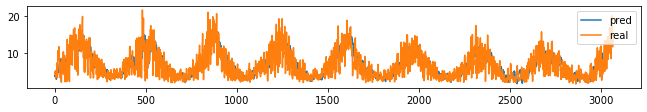

(0.3650737502251522, 1.9942158242630983)

In [63]:
runDESN(um,lm,rem,ram,lem,True,True)

Training MAPE:  0.35815147274472175
Training MAE:  5.4324512114314985 

Test MAPE:  0.3650737502251522
Test MAE:  1.9942158242630983 



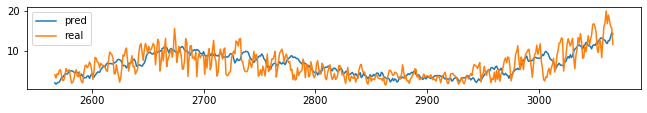

(0.3650737502251522, 1.9942158242630983)

In [64]:
runDESN(um,lm,rem,ram,lem,True,True,500)

In [69]:
import re
ums,lms,rems,rams,lems,mapes = [],[],[],[],[] ,[]
with open('desnResults.txt') as fp:
    for line in fp:
        m = re.search('units:([\d\.]+), layers:([\d\.]+),reg:([\d\.]+),radius:([\d\.]+),leaky:([\d\.]+) -->> MAPE:([\d\.]+), MAE:([\d\.]+)', line)
        c=1
        for l in [ums,lms,rems,rams,lems,mapes]:
            l.append(float(m.group(c)))
            c+=1
            


In [70]:
def to_df(l1,l2):
    d =  np.asarray([l1,l2]).T
    df = pd.DataFrame(d, columns=["x", "y"])
    return df



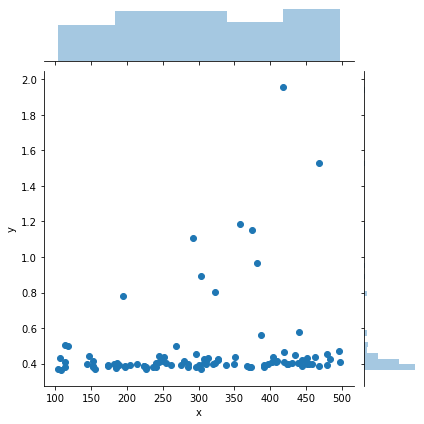

In [71]:
# Mape by units
sns.jointplot(x="x", y="y", data=to_df(ums,mapes))


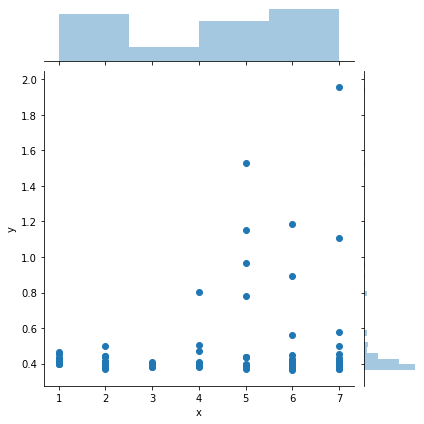

In [72]:
# mape by layers
sns.jointplot(x="x", y="y", data=to_df(lms,mapes))

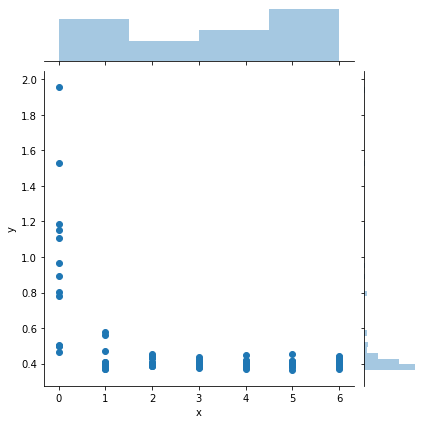

In [73]:
sns.jointplot(x="x", y="y", data=to_df(rems,mapes))
# Mape by regularization. Seems like it's always good to have some regularization

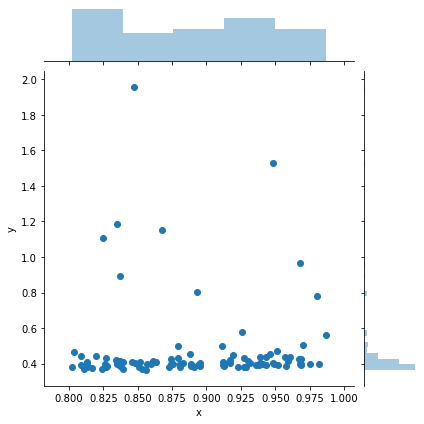

In [74]:
sns.jointplot(x="x", y="y", data=to_df(rams,mapes))


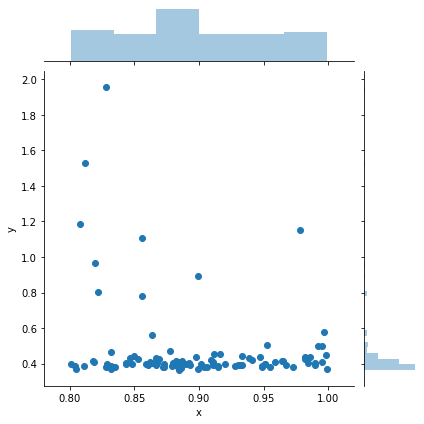

In [75]:
sns.jointplot(x="x", y="y", data=to_df(lems,mapes))


In [76]:
# None of the features seem to be strictly responsible for prediction accuracy :/

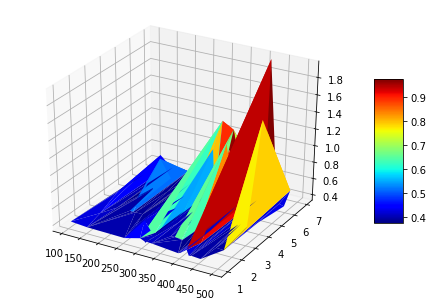

In [77]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(np.asarray(ums), np.asarray(lms), np.asarray(mapes), cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [78]:
#let's delete outliers

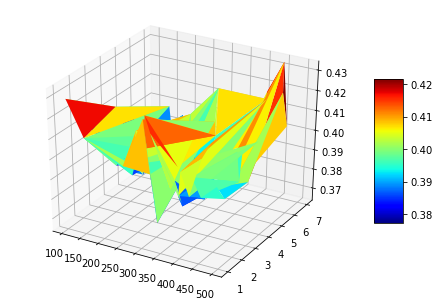

In [79]:
#75 best configurations
mapes_sortorder = np.argsort(np.array(mapes))
mapes_sorted = np.array(mapes)[mapes_sortorder][:-25]
ums_sorted = np.array(ums)[mapes_sortorder][:-25]
lms_sorted = np.array(lms)[mapes_sortorder][:-25]
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(ums_sorted,lms_sorted,mapes_sorted, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

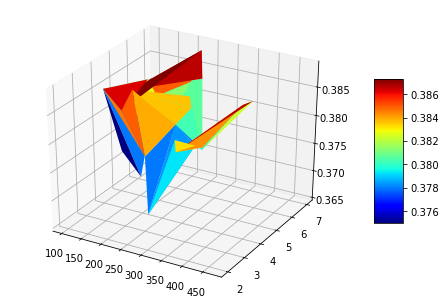

In [80]:
#25 best configs
mapes_sortorder = np.argsort(np.array(mapes))
mapes_sorted = np.array(mapes)[mapes_sortorder][:-75]
ums_sorted = np.array(ums)[mapes_sortorder][:-75]
lms_sorted = np.array(lms)[mapes_sortorder][:-75]
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(ums_sorted,lms_sorted,mapes_sorted, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [115]:
#NO clear patterns can be spotted

## Podsumowanie
1. Stworzyłem konfigurowalny Dataset MackeyGlass
2. Z wykorzystaniem biblioteki Echotorch probowalem przewidywac n krokow do przodu
3. Zwykły ESN radził sobie podobnie jak inne sieci neuronowe przedstawione w paperze (tym peirwszym). Glęboki ESN troche lepiej
4. Porownałem wyniki z 2 paperami - ciezko bylo znalezc jakies o mackeyglass wiec byly to pierwsze 2, ktore znalazłem
5. Na najlepiej działającym deepESNie spróbowałem ekstrapolacji. 50krokow do przodu działał bardzo dobrze, 100 całkiem nieźle, przy 150 zaczynał juz byc niestabilny.
6. Potem przyszła pora na nowy zbiór -https://www.kaggle.com/epa/epa-historical-air-quality Przy nim zaczęły wychodzic wady EchoTorch
7. Zrobiłem 2 datasety - Windowed (dostaje przedział [n,m], przewiduje [m+1,m+k+1]) i shifted ( dostaje przedział [n,m] przewiduje [n+k,m+k]. Na oknach zwracał wyniki ale wyglądały na totlanie losowe bez względu na to jak dobierałem hiperparametry, przesunięcie w ogóle nie działało bo zawsze trafiał na macierz osobliwą (w Readout próbuje rozwiązać układ równan używając faktoryzacji LU)
8. Zmieniłem bibliotekę na https://github.com/lucapedrelli/DeepESN - napisaną pod paper o DeepESN. Ona tez jest dosc ograniczona, ale działa! 
Co prawda średni MAPE na poziomie 36%, ale jak się przybliży to widać, że ładnie wygładza wykres. Zacząłem szukać zależności między hiperparametrami -głównie szerokością i głębokością sieci a wynikami ale poza tym, że zawsze regularyzacja pomaga to nie znalazłem nic oczywistego. MOże jeszcze porysuje jakieś korelacje i spróbuję ekstrapolacji.
9. Do zrobienia - sprobowac przewidywac na https://www.kaggle.com/camnugent/sandp500 i porównac się z Yuriim 